In [1]:
import tensorflow as tf #version 2.9
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import seaborn as sns
import matplotlib.cm as cm


d:\0. PROGRAMMES SSD\Anaconda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_dataset():
	"""loads the MNIST dataset"""
	(trainX, trainY), (testX, testY) = tf.keras.datasets.mnist.load_data()

	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	trainY = tf.keras.utils.to_categorical(trainY)
	testY = tf.keras.utils.to_categorical(testY)
	
	trainX = trainX.astype('float32')
	testX = testX.astype('float32')
	trainX = trainX / 255.0
	testX = testX / 255.0

	return trainX, trainY, testX, testY

# define cnn model
def define_model():
	"""
	Simplest model : 1 ConvLayer, 1 FullyConnLayer
	"""
	model = tf.keras.models.Sequential()
	model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(layers.MaxPooling2D((2, 2)))
	model.add(layers.Flatten())
	model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(layers.Dense(10, activation='softmax'))
	
	opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

trainX, trainY, testX, testY = load_dataset()


In [72]:
model_simple = define_model()

history = model_simple.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose=1)

_, acctrain = model_simple.evaluate(trainX, trainY, verbose=0)
_, acctest = model_simple.evaluate(testX, testY, verbose=0)
print('Accuracy on train data > %.3f' % (acctrain * 100.0))
print('Accuracy on test data > %.3f' % (acctest * 100.0))


Epoch 1/5
1875/1875 [==============================] - 18s 6ms/step - loss: 0.1663 - accuracy: 0.9501 - val_loss: 0.0768 - val_accuracy: 0.9763
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0596 - accuracy: 0.9816 - val_loss: 0.0525 - val_accuracy: 0.9832
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0473 - val_accuracy: 0.9845
Epoch 4/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0271 - accuracy: 0.9919 - val_loss: 0.0436 - val_accuracy: 0.9851
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0417 - val_accuracy: 0.9863
Accuracy on train data > 99.633
Accuracy on test data > 98.630


load mnist model to not do training again

In [27]:
# model_simple.save('models/mnist_cnn.h5')
# mnist_model = tf.keras.models.load_model("models/mnist_model.h5")

GRAD-CAM

In [3]:
def grad_cam(input_model, image, category_index, layer_name):
    """
    returns the heatmap corresponding to the gradients of the considered layer
    - image is in format (1, width, height, 1 if grey or 3 if rgb)
    - category_index is the index of the class we want to analyse (--> the predicted class of image)
    - layer_name  (--> last ConvLayer before classification)
    """    
    grad_model = tf.keras.models.Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output,
                    input_model.output]
    ) #returns the prediction and activation of the layer we want to analyse
    
    with tf.GradientTape() as tape:
        inputs = image
        last_conv_layer_output, preds = grad_model(inputs)
        class_channel = preds[:, category_index] # get the probability of the chosen class
    grads = tape.gradient(class_channel, last_conv_layer_output) #computes the gradient of yc with respect to Akij, 
    #size (1, layer_x, layer_y, layer_channel)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) #averages over i j to obtain alpha_c_k
    #size (layer_channel)

    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] #computes \sum_k alpha_c_k * Akij
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) #relu

    return heatmap.numpy()


In [4]:

def generate_heatmap(model, image, layer) : 
    """returns the heatmap of the predicted label of image by the model"""
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions) #selecting the highest probability class

    print(f'Predicted class: {predicted_class}')
    heatmap = grad_cam(model, image, predicted_class, layer)
    
    return heatmap

def print_superimpose(img, heatmap, alpha, title="") : 
    """superimposes the heatmap on image
        - img is of size (width, height, 1 or 3)
        - alpha is the transparency of the heatmap
        
    """
    heatmap = np.uint8(255 * heatmap)
    
    color_map = cm.get_cmap("jet")
    color_map = color_map(np.arange(256))[:, :3]
    color_map = color_map[heatmap]
    color_map = tf.keras.preprocessing.image.array_to_img(color_map)
    color_map = color_map.resize(img.shape[:2])
    color_map = tf.keras.preprocessing.image.img_to_array(color_map)
    if len(img.shape) == 2 :
        img = tf.tile(tf.expand_dims(img, axis=2), [1,1,3])
    
    superimposed_img = color_map * alpha + (1-alpha) * img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    plt.title(title)
    plt.imshow(superimposed_img, cmap='jet')
    

1/1 [==============================] - 0s 33ms/step
Predicted class: 5


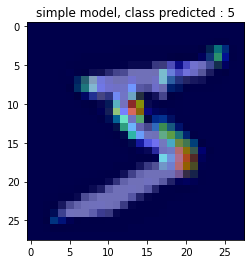

In [80]:
#Generating explanations for the simplest model

n_image = 0 #index of the image we want to analyse
img  = trainX[n_image:n_image+1]

heatmap = generate_heatmap(model_simple, img, 'conv2d_20')
# sns.heatmap(heatmap)
print_superimpose(img[0], heatmap, 0.005, "simple model, class predicted : 5")

In [81]:
def define_model2():
    """
    More advanced model : 2CL with dropout + 2FCL
    """
    model = tf.keras.models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13,13,2)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(10, activation='softmax'))
    print(model.summary())
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
#training of more advanced model

trainX, trainY, testX, testY = load_dataset()
model_dropout = define_model2()
history = model_dropout.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose=1)

_, acctrain = model_dropout.evaluate(trainX, trainY, verbose=0)
_, acctest = model_dropout.evaluate(testX, testY, verbose=0)
print('Accuracy on train data > %.3f' % (acctrain * 100.0))
print('Accuracy on test data > %.3f' % (acctest * 100.0))

model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)         

1/1 [==============================] - 0s 18ms/step
Predicted class: 1


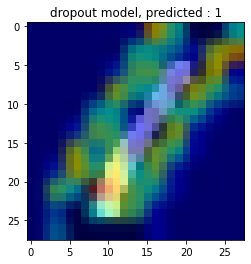

In [44]:
#Generating explanations for the more advanced model

n_image = 3
img = trainX[n_image:n_image+1]

heatmap = generate_heatmap(model_dropout, img, "conv2d_3")
print_superimpose(img[0], heatmap, 0.005, "dropout model, predicted : 1")

In [6]:
def define_modelDA():
    """ adding data augmentation """
    model = tf.keras.models.Sequential()

    #very bad choice of augmentation, rotation and flip are important for prediction.
    #model.add(layers.RandomFlip("horizontal_and_vertical")) 
    #model.add(layers.RandomRotation(0.2))

    #tf2.9 bug, very slow (WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip), to do : use other method to do data augmentation
    model.add(layers.RandomTranslation(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), fill_mode="constant", fill_value=0.0))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13,13,2)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(10, activation='softmax'))
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

trainX, trainY, testX, testY = load_dataset()
model_DA = define_modelDA()

history = model_DA.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose=1)

_, acctrain = model_DA.evaluate(trainX, trainY, verbose=0)
_, acctest = model_DA.evaluate(testX, testY, verbose=0)
print('Accuracy on train data > %.3f' % (acctrain * 100.0))
print('Accuracy on test data > %.3f' % (acctest * 100.0))

model_DA.summary()

Epoch 1/5
1875/1875 [==============================] - 674s 358ms/step - loss: 1.4580 - accuracy: 0.4731 - val_loss: 0.4412 - val_accuracy: 0.8547
Epoch 2/5
1875/1875 [==============================] - 678s 362ms/step - loss: 0.8977 - accuracy: 0.6853 - val_loss: 0.2506 - val_accuracy: 0.9193
Epoch 3/5
1875/1875 [==============================] - 673s 359ms/step - loss: 0.7430 - accuracy: 0.7396 - val_loss: 0.1974 - val_accuracy: 0.9387
Epoch 4/5
1875/1875 [==============================] - 692s 369ms/step - loss: 0.6668 - accuracy: 0.7658 - val_loss: 0.1196 - val_accuracy: 0.9634
Epoch 5/5
1875/1875 [==============================] - 695s 371ms/step - loss: 0.6216 - accuracy: 0.7835 - val_loss: 0.1129 - val_accuracy: 0.9665
Accuracy on train data > 96.078
Accuracy on test data > 96.650
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation_1 (Rando  (None, 28, 28, 1) 

1/1 [==============================] - 0s 15ms/step
Predicted class: 4


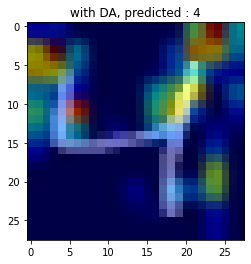

In [18]:
n_image = 2
img = trainX[n_image:n_image+1]
heatmap = generate_heatmap(model_DA, img, "conv2d_3")
print_superimpose(img[0], heatmap, 0.005, "with DA, predicted : 4")

In [56]:
def load_dataset_cifar():
	(trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()

	trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
	testX = testX.reshape((testX.shape[0], 32, 32, 3))
	trainY = tf.keras.utils.to_categorical(trainY)
	testY = tf.keras.utils.to_categorical(testY)
	
	trainX = trainX.astype('float32')
	testX = testX.astype('float32')
	trainX = trainX / 255.0
	testX = testX / 255.0

	return trainX, trainY, testX, testY

def define_model_cifar():
    """ changing input size """
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(13,13,3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(10, activation='softmax'))
    print(model.summary())
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cifar_trainX, cifar_trainY, cifar_testX, cifar_testY = load_dataset_cifar()
print(cifar_trainY.shape)
cifar_model = define_model_cifar()

history = cifar_model.fit(cifar_trainX, cifar_trainY, epochs=5, batch_size=32, validation_data=(cifar_testX, cifar_testY), verbose=1)

_, acctrain = cifar_model.evaluate(cifar_trainX, cifar_trainY, verbose=0)
_, acctest = cifar_model.evaluate(cifar_testX, cifar_testY, verbose=0)
print('Accuracy on train data > %.3f' % (acctrain * 100.0))
print('Accuracy on test data > %.3f' % (acctest * 100.0))


(50000, 10)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 6, 6,

1/1 [==============================] - 0s 17ms/step
Predicted class: 9


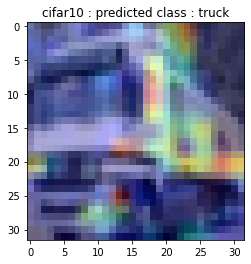

In [68]:

n_image = 1
img  = cifar_trainX[n_image:n_image+1]
# airplane automobile bird cat deer dog, frog horse ship truck
heatmap = generate_heatmap(cifar_model, img, 'conv2d_19')
# sns.heatmap(heatmap)

print_superimpose(img[0], heatmap, 0.002, "cifar10 : predicted class : truck")

{'loss': [0.886446475982666,
  0.43840599060058594,
  0.35246896743774414,
  0.31051185727119446,
  0.2826809287071228],
 'accuracy': [0.6970666646957397,
  0.859749972820282,
  0.8858333230018616,
  0.8993499875068665,
  0.9077833294868469],
 'val_loss': [0.3882640302181244,
  0.27941834926605225,
  0.22845394909381866,
  0.19884613156318665,
  0.2107381820678711],
 'val_accuracy': [0.8686000108718872,
  0.9068999886512756,
  0.9271000027656555,
  0.9351000189781189,
  0.9286999702453613]}